# Titanic - Clasificación binaria
### Clasificación de sobrevivientes
---

_La clasificacion binaria consiste en que la salida debe ser 0 o 1._

_Se busca a travez de seis caracteristicas ('Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare') la predicción sobre cual persona sobrevivio o no_

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input,LeakyReLU,BatchNormalization,Activation
from tensorflow.keras.models import Model, load_model
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trainData = pd.read_csv('../datasets/titanic/train.csv')
testData = pd.read_csv('../datasets/titanic/test.csv')

trainData.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [3]:
def process_data(data):
    xt = data[['Pclass','Sex', 'Age', 'SibSp', 'Parch', 'Fare']]
    xt = xt.fillna(xt.mean())

    xt['Sex'] = xt['Sex'].replace(['female','male'],[0,1]).values
    xt['Pclass'] = xt['Pclass'] - 1
    
    return xt

In [4]:
xt = process_data(trainData)
xtest = process_data(testData)

xt.tail()

,Pclass,Sex,Age,SibSp,Parch,Fare
886,1,1,27.000000,0,0,13.00
887,0,0,19.000000,0,0,30.00
888,2,0,29.699118,1,2,23.45
889,0,1,26.000000,0,0,30.00
890,2,1,32.000000,0,0,7.75


In [5]:
# Pasamos la etiqueta survivde que está en formato texto
# a 0 y 1

yt = trainData["Survived"]
yt

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 891, dtype: int64

In [6]:
ytonehot = tf.keras.utils.to_categorical(yt, num_classes=2)

print(ytonehot)
ytonehot.shape

[[1. 0.]
 [0. 1.]
 [0. 1.]
 ...
 [1. 0.]
 [0. 1.]
 [1. 0.]]


(891, 2)

In [7]:
# Pasamos de lista a formato np.array

arraytrainx=np.array(xt)
arraytrainy=np.array(yt)

## Creación del modelo
------

In [8]:
Entradas = Input(shape=(6,))
x = Dense(200)(Entradas)

'''
 BatchNormalization deja los datos 
 en una media de 0 
 y una desviación tipica de 1
 para que la escala no afecte tanto al modelo
'''
x = BatchNormalization()(x)

'''
 a LeakyReLU se le asignará un pendiente
 del lado negativo de 0.05 
 para que mejore la velocidad de entrenamiento
 Y disminuya la convergencia
'''

x = LeakyReLU(alpha=0.05)(x)

# x = Dropout(0.15)(x)

x = Dense(50)(x)
x = BatchNormalization()(x)
x = LeakyReLU(alpha=0.05)(x)

# x = Dropout(0.1)(x)

x = Dense(1)(x)

'''
Ya que tenemos una clasificación binaria
introducimos una activación sigmoidal 
en la capa de salida
'''

x = Activation('sigmoid')(x)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
modelo = Model(inputs=Entradas, outputs = x)

In [10]:
'''
Definimos el metodo de guardado del modelo
Primera variable es el nombre para guardar modelo
monitor verá la variable a seguir para definir el mejor modelo
Verbose: 0 para que no nos muestre informarción en el fit
save_best_only si queremos solo guardar el mejor modelo
'''

Guardado = tf.keras.callbacks.ModelCheckpoint('model_backup.h5', monitor='val_acc', verbose=0, save_best_only=True,save_weights_only=False, mode='auto', period=1)

In [11]:
# Definimos optimizador del modelo

Adam = tf.keras.optimizers.Adam(lr=0.0001,beta_1=0.9,beta_2=0.9)

In [12]:
# Compilamos el modelo

'''
Metrics=['accuracy'] marcará si el valor que queremos que sea 1
Está por encima de 0.5 o si está por debajo
lo pasará a 0 o 1 correspondientemente

Como es una clasificación binaria la metrica tiene que ser: accuracy
'''

modelo.compile(loss='binary_crossentropy', optimizer=Adam, metrics=['accuracy'])
modelo.summary()

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense (Dense)                (None, 200)               1400      
_________________________________________________________________
batch_normalization (BatchNo (None, 200)               800       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                10050     
_________________________________________________________________
batch_normalization_1 (Batch (None, 50)                200       
_________________________________

## Entrenamiento 
----

In [13]:
history=modelo.fit(arraytrainx,arraytrainy ,epochs=400, batch_size=200,validation_split=0.2,callbacks=[Guardado],verbose=0)

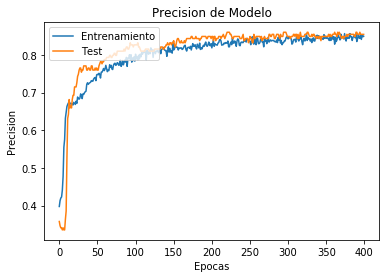

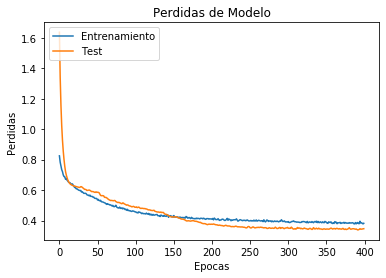

In [14]:
plt.figure(1)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Precision de Modelo')
plt.ylabel('Precision')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Test'], loc='upper left')


plt.figure(2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Perdidas de Modelo')
plt.ylabel('Perdidas')
plt.xlabel('Epocas')
plt.legend(['Entrenamiento', 'Test'], loc='upper left')
plt.show()